In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, csr_matrix, block_diag, identity, hstack
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
from sksparse.cholmod import cholesky

from pyiga import bspline
from pyiga import utils
from pyiga.bspline import BSplineFunc
from pyiga.tensor import apply_tprod
from pyiga import adaptive as adap

import functools
import itertools

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [15]:
def draw_loglog_slope(fig, ax, origin, width_inches, slope, inverted=False, color=None, polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None):
    """
    This function draws slopes or "convergence triangles" into loglog plots.
    @param fig: The figure
    @param ax: The axes object to draw to
    @param origin: The 2D origin (usually lower-left corner) coordinate of the triangle
    @param width_inches: The width in inches of the triangle
    @param slope: The slope of the triangle, i.e. order of convergence
    @param inverted: Whether to mirror the triangle around the origin, i.e. whether 
        it indicates the slope towards the lower left instead of upper right (defaults to false)
    @param color: The color of the of the triangle edges (defaults to default color)
    @param polygon_kwargs: Additional kwargs to the Polygon draw call that creates the slope
    @param label: Whether to enable labeling the slope (defaults to true)
    @param labelcolor: The color of the slope labels (defaults to the edge color)
    @param label_kwargs: Additional kwargs to the Annotation draw call that creates the labels
    @param zorder: The z-order value of the triangle and labels, defaults to a high value
    """

    if polygon_kwargs is None:
        polygon_kwargs = {}
    if label_kwargs is None:
        label_kwargs = {}

    if color is not None:
        polygon_kwargs["color"] = color
    if "linewidth" not in polygon_kwargs:
        polygon_kwargs["linewidth"] = 0.75 * mpl.rcParams["lines.linewidth"]
    if labelcolor is not None:
        label_kwargs["color"] = labelcolor
    if "color" not in label_kwargs:
        label_kwargs["color"] = polygon_kwargs["color"]
    if "fontsize" not in label_kwargs:
        label_kwargs["fontsize"] = 0.75 * mpl.rcParams["font.size"]

    if inverted:
        width_inches = -width_inches
    if zorder is None:
        zorder = 10

    # For more information on coordinate transformations in Matplotlib see
    # https://matplotlib.org/3.1.1/tutorials/advanced/transforms_tutorial.html

    # Convert the origin into figure coordinates in inches
    origin_disp = ax.transData.transform(origin)
    origin_dpi = fig.dpi_scale_trans.inverted().transform(origin_disp)

    # Obtain the top-right corner in data coordinates
    corner_dpi = origin_dpi + width_inches * np.array([1.0, 0.0])
    corner_disp = fig.dpi_scale_trans.transform(corner_dpi)
    corner = ax.transData.inverted().transform(corner_disp)

    (x1, y1) = (origin[0], origin[1])
    x2 = corner[0]

    # The width of the triangle in data coordinates
    width = x2 - x1
    # Compute offset of the slope
    log_offset = y1 / (x1 ** (-slope))

    y2 = log_offset * (x2 ** (-slope))
    height = y2 - y1

    # The vertices of the slope
    a = origin
    b = corner
    c = [x2, y2]

    # Draw the slope triangle
    X = np.array([a, b, c])
    triangle = plt.Polygon(X[:3,:], fill=False, zorder=zorder, **polygon_kwargs)
    ax.add_patch(triangle)

    # Convert vertices into display space
    a_disp = ax.transData.transform(a)
    b_disp = ax.transData.transform(b)
    c_disp = ax.transData.transform(c)

    # Figure out the center of the triangle sides in display space
    bottom_center_disp = a_disp + 0.5 * (b_disp - a_disp)
    bottom_center = ax.transData.inverted().transform(bottom_center_disp)

    right_center_disp = b_disp + 0.5 * (c_disp - b_disp)
    right_center = ax.transData.inverted().transform(right_center_disp)

    # Label alignment depending on inversion parameter
    va_xlabel = "bottom" if not inverted else "top"
    ha_ylabel = "left" if not inverted else "right"

    # Label offset depending on inversion parameter
    offset_xlabel = [0.0, 0.33 * label_kwargs["fontsize"]] if not inverted else [0.0, -0.33 * label_kwargs["fontsize"]]
    offset_ylabel = [0.33 * label_kwargs["fontsize"], 0.0] if not inverted else [-0.33 * label_kwargs["fontsize"], 0.0]

    # Draw the slope labels
    ax.annotate("$1$", bottom_center, xytext=offset_xlabel, textcoords='offset points', ha="center", va=va_xlabel, zorder=zorder, **label_kwargs)
    ax.annotate(f"${slope}$", right_center, xytext=offset_ylabel, textcoords='offset points', ha=ha_ylabel, va="center", zorder=zorder, **label_kwargs)


In [16]:
def Inductor(deg,N):
    kvs=42*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    
    geos=[      
        geometry.unit_square().scale((0.5)).translate((-0.5,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,-0.5)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,-0.5)),
        geometry.unit_square().scale(0.5).translate((1.5,-0.5)),
        
        geometry.unit_square().scale((0.5,0.25)).translate((-0.5,0)),
        geometry.unit_square().scale(0.25),
        geometry.unit_square().scale(0.25).translate((0.25,0)),
        geometry.unit_square().scale((0.5,0.25)).translate((0.5,0)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.,0)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.25,0)),
        geometry.unit_square().scale((0.5,0.25)).translate((1.5,0)),
        
        geometry.unit_square().scale((0.5,0.025)).translate((-0.5,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((0,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((0.25,0.25)),
        geometry.unit_square().scale((0.5,0.025)).translate((0.5,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((1.,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((1.25,0.25)),
        geometry.unit_square().scale((0.5,0.025)).translate((1.5,0.25)),
        
        geometry.unit_square().scale((0.5,0.5)).translate((-0.5,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,0.275)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,0.275)),
        geometry.unit_square().scale((0.5,0.5)).translate((1.5,0.275)),
        
        geometry.unit_square().scale((0.5,0.25)).translate((-0.5,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((0,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((0.25,0.775)),
        geometry.unit_square().scale((0.5,0.25)).translate((0.5,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.25,0.775)),
        geometry.unit_square().scale((0.5,0.25)).translate((1.5,0.775)),
        
        geometry.unit_square().scale(0.5).translate((-0.5,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,1.025)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,1.025)),
        geometry.unit_square().scale(0.5).translate((1.5,1.025)),
         ]
    patches=list(zip(kvs,geos))
    M = topology.PatchMesh(patches)
    M.rename_domain(0,'Air')
    M.set_domain_id({'Fe':{8,9,10,11,12,22,24,26,29,30,31,32,33}, 'C1':{23}, 'C2':{25}})
    return M

In [17]:
mu0 = 4*pi*1e-7
nu = {'C1': 1/mu0, 'C2':1/mu0, 'Fe':1/(2500*mu0), 'Air': 1/mu0}
j = {'C1': lambda x,y: 66/(0.125), 'C2':lambda x,y: -66/(0.125), 'Fe':lambda x,y: 0.0, 'Air': lambda x,y: 0.0}
MaT = {'C1': lambda x,y: (0.,0.), 'C2': lambda x,y:(0.,0.), 'Fe':lambda x,y:(0.,0.), 'Air': lambda x,y:(0.,0.)}

In [18]:
def uniform(deg, maxiter=5):
    M = Inductor(deg,deg+1)
    MP = assemble.Multipatch(M, automatch=True)
    uh=[]
    numdofs = np.zeros(maxiter,dtype=float)
    P=[]
    return_P = True
    Eh=np.zeros(maxiter)
    
    time_mesh = np.zeros(maxiter)
    time_solve = np.zeros(maxiter)

    for i in range(maxiter):
        print('----------------------------------------------------')
        print(i)
        bcs = MP.compute_dirichlet_bcs({0:0.})
        Ah = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
        F = sum([MP.assemble_volume('(j * v) * dx', arity=1, domain_id=k, j=j[k], physical=True) for k in j],axis=0)
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        Mh = MP.assemble_volume(vform.mass_vf(2))
        LS = assemble.RestrictedLinearSystem(Ah, F, bcs)
        uh.append(LS.complete((cholesky(LS.A.tocsc()))(LS.b)))
        numdofs[i] = MP.numdofs
        Eh[i] = MP.integrate('0.5 * nu * inner(grad(uh),grad(uh)) * v * dx', u_ =uh[-1], nu=nu)*0.0254
        print('Number of doFs: ' + str(MP.numdofs))
        print('Energy: ' + str(0.0254 * 0.5 * uh[-1] @ Ah @ uh[-1]))

        if i < maxiter-2:
            P.append(MP.h_refine(h_ref=-1, return_P=return_P))
        elif i == maxiter-2:
            P.append(MP.p_refine(p_inc=1, return_P=return_P))
        else:
            pass

    for k in reversed(range(1,len(P))):
        P[k-1]=P[k]@P[k-1]

    L2err = np.zeros(maxiter)
    H1err = np.zeros(maxiter)
    Aherr = np.zeros(maxiter)
    Eherr = np.zeros(maxiter)
    for i in range(len(uh)-1):
        eh = P[i]@uh[i]-uh[-1]
        L2err[i] = eh @ Mh @ eh
        H1err[i] = eh @ Kh @ eh + L2err[i]
        Aherr[i] = eh @ Ah @ eh

    L2err = sqrt(L2err)
    H1err = sqrt(H1err)
    Aherr = sqrt(Aherr)
    
    return MP, numdofs, uh, L2err, H1err, Aherr, time_mesh, time_solve

In [6]:
def geometric(deg, maxiter=15, returnP =True):
    M = Inductor(deg,deg+1)
    MP = assemble.Multipatch(M, automatch=True)
    uh=[]
    numdofs = np.zeros(maxiter,dtype=float)
    P=[]
    return_P = True
    Eh=np.zeros(maxiter)
    
    time_mesh = np.zeros(maxiter)
    time_solve = np.zeros(maxiter)

    for i in range(maxiter):
        print('----------------------------------------------------')
        print(i)
        bcs = MP.compute_dirichlet_bcs({0:0.})
        Ah = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
        F = sum([MP.assemble_volume('(j * v) * dx', arity=1, domain_id=k, j=j[k], physical=True) for k in j],axis=0)
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        Mh = MP.assemble_volume(vform.mass_vf(2))
        LS = assemble.RestrictedLinearSystem(Ah, F, bcs)
        
        t=time.time()
        uh.append(LS.complete((cholesky(LS.A.tocsc()))(LS.b)))
        time_solve[i]=time.time()-t
        
        numdofs[i] = MP.numdofs
        #Eh[i] = MP.integrate('0.5 * nu * inner(grad(uh),grad(uh)) * v * dx', u_ =uh[-1], nu=nu)*0.0254
        print('Number of doFs: ' + str(MP.numdofs))
        print('Energy: ' + str(0.0254 * 0.5 * uh[-1] @ Ah @ uh[-1]))

        t = time.time()
        if i < maxiter-2:
            if i%5==0:
                P.append(MP.h_refine(h_ref=-1, return_P=return_P))
            else:
                P.append(MP.h_refine(h_ref='q', return_P=return_P))
        elif i == maxiter-2:
            P.append(MP.p_refine(p_inc=1, return_P=return_P))
        else:
            pass
        time_mesh[i] = time.time()-t

    for k in reversed(range(1,len(P))):
        P[k-1]=P[k]@P[k-1]

    L2err = np.zeros(maxiter)
    H1err = np.zeros(maxiter)
    Aherr = np.zeros(maxiter)
    Eherr = np.zeros(maxiter)
    
    if returnP:
        for i in range(len(uh)-1):
            eh = P[i]@uh[i]-uh[-1]
            L2err[i] = eh @ Mh @ eh
            H1err[i] = eh @ Kh @ eh + L2err[i]
            Aherr[i] = eh @ Ah @ eh

        L2err = sqrt(L2err)
        H1err = sqrt(H1err)
        Aherr = sqrt(Aherr)
    
    return MP, numdofs, uh, L2err, H1err, Aherr, time_mesh, time_solve

In [11]:
for deg, maxiter in zip((2,3,4),(8,7,7)):
    MP, numdofs, uh, L2err, H1err, Aherr, time_mesh, time_solve = uniform(deg,maxiter)
    np.savetxt('Ip'+str(deg)+'n'+str(deg+1)+'uni.txt', np.c_[[numdofs,H1err,L2err,Aherr,time_mesh,time_solve]])

Basis setup took 0.013554573059082031 seconds
----------------------------------------------------
0
Number of doFs: 725
Energy: 0.0008654770655053184
Refinement took 0.0014832019805908203 seconds for 42 patches.
Basis setup took 0.015418767929077148 seconds
Prolongation took 0.07793378829956055 seconds
----------------------------------------------------
1
Number of doFs: 2150
Energy: 0.0008763649541303452
Refinement took 0.00150299072265625 seconds for 42 patches.
Basis setup took 0.01974201202392578 seconds
Prolongation took 0.08358502388000488 seconds
----------------------------------------------------
2
Number of doFs: 7268
Energy: 0.0008815644860982698
Refinement took 0.0014317035675048828 seconds for 42 patches.
Basis setup took 0.0342557430267334 seconds
Prolongation took 0.09687328338623047 seconds
----------------------------------------------------
3
Number of doFs: 26576
Energy: 0.0008836790055448084
Refinement took 0.001447916030883789 seconds for 42 patches.
Basis setup 

CholmodTooLargeError: ../Supernodal/cholmod_super_symbolic.c:683: problem too large (code -3)

In [7]:
for deg, maxiter in zip((2,3,4),(20,20,20)):
    MP_geo, numdofs_geo, uh, L2err_geo, H1err_geo, Aherr_geo, Eherr_geo = geometric(deg,maxiter)
    np.savetxt('Ip'+str(deg)+'n'+str(deg+1)+'geo.txt', np.c_[[numdofs_geo,H1err_geo,L2err_geo,Aherr_geo]])

Basis setup took 0.014196634292602539 seconds
----------------------------------------------------
0
Number of doFs: 725
Energy: 0.0008654770655053184
Refinement took 0.00035881996154785156 seconds for 10 patches.
Basis setup took 0.01878643035888672 seconds
Prolongation took 0.01829075813293457 seconds
----------------------------------------------------
1
Number of doFs: 911
Energy: 0.0008707991823023046
Refinement took 0.0004639625549316406 seconds for 10 patches.
Basis setup took 0.019544124603271484 seconds
Prolongation took 0.01851058006286621 seconds
----------------------------------------------------
2
Number of doFs: 1177
Energy: 0.0008729006693018193
Refinement took 0.0003752708435058594 seconds for 10 patches.
Basis setup took 0.020251989364624023 seconds
Prolongation took 0.018601179122924805 seconds
----------------------------------------------------
3
Number of doFs: 1523
Energy: 0.0008735139626060073
Refinement took 0.0003714561462402344 seconds for 10 patches.
Basis s

Basis setup took 0.013402700424194336 seconds
------------------------------------------------------
0
Number of DoFs: 725
Energy: 0.0008136772762026942
Residual contributions took 0.2700076103210449 seconds.
Jump contributions took 0.4350752830505371 seconds.
Refinement took 0.05227303504943848 seconds for 9 patches.
Basis setup took 0.023427486419677734 seconds
Prolongation took 0.06395435333251953 seconds


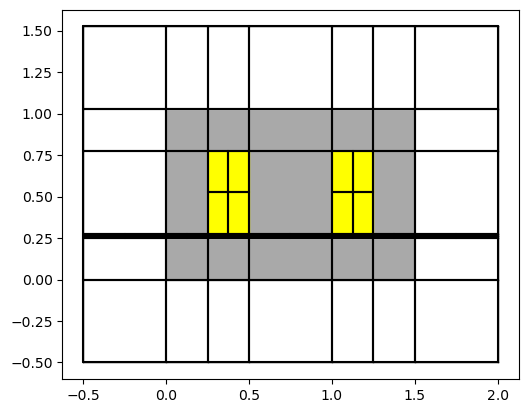

------------------------------------------------------
1
Number of DoFs: 1125
Energy: 0.0008384212218092091
Residual contributions took 0.43797874450683594 seconds.
Jump contributions took 0.9354395866394043 seconds.
Refinement took 0.15961194038391113 seconds for 19 patches.
Basis setup took 0.03569936752319336 seconds
Prolongation took 0.13353991508483887 seconds


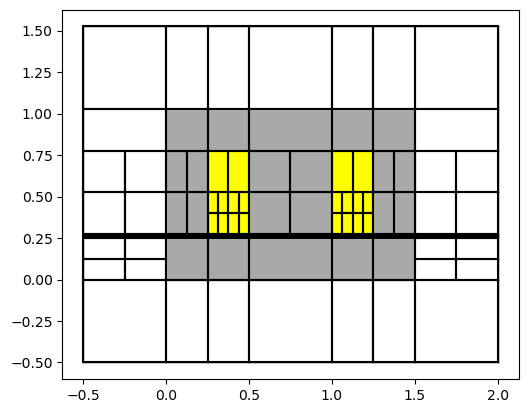

------------------------------------------------------
2
Number of DoFs: 1985
Energy: 0.000856660371308465
Residual contributions took 0.7964770793914795 seconds.
Jump contributions took 1.8960819244384766 seconds.
Refinement took 0.3599581718444824 seconds for 28 patches.
Basis setup took 0.0727694034576416 seconds
Prolongation took 0.19736671447753906 seconds


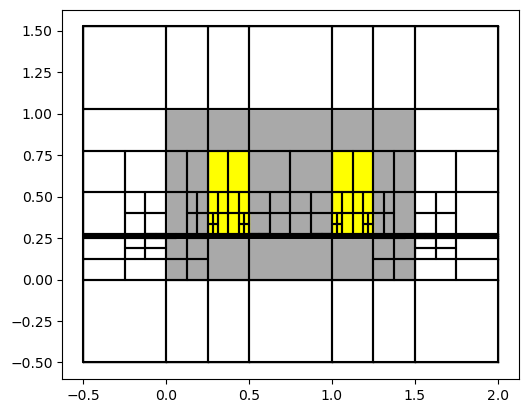

------------------------------------------------------
3
Number of DoFs: 3221
Energy: 0.0008687722056413158
Residual contributions took 1.3167808055877686 seconds.
Jump contributions took 3.3201651573181152 seconds.
Refinement took 0.5581181049346924 seconds for 31 patches.
Basis setup took 0.0962822437286377 seconds
Prolongation took 0.21767711639404297 seconds


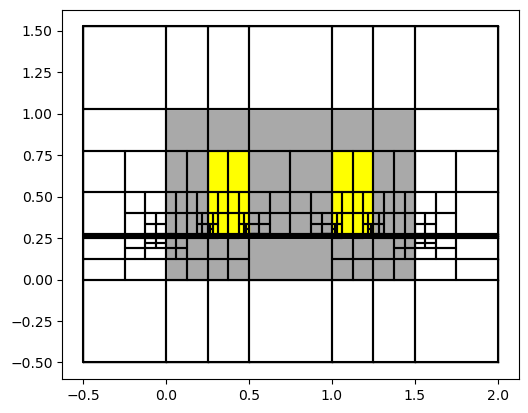

------------------------------------------------------
4
Number of DoFs: 4633
Energy: 0.0008754843568348888
Residual contributions took 1.8800759315490723 seconds.
Jump contributions took 4.830690383911133 seconds.
Refinement took 0.8978490829467773 seconds for 37 patches.
Basis setup took 0.12738847732543945 seconds
Prolongation took 0.26223182678222656 seconds


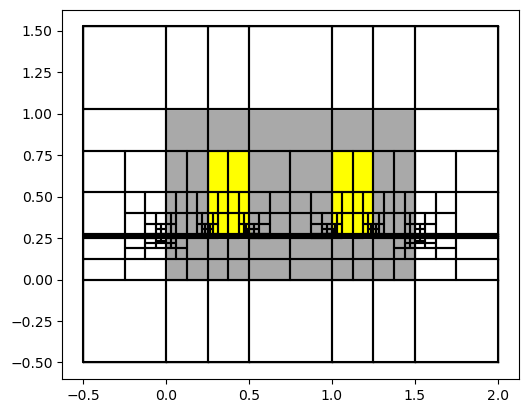

------------------------------------------------------
5
Number of DoFs: 6261
Energy: 0.0008789471047938762
Residual contributions took 2.5603363513946533 seconds.
Jump contributions took 6.706434726715088 seconds.
Refinement took 1.5327887535095215 seconds for 47 patches.
Basis setup took 0.17897796630859375 seconds
Prolongation took 0.3397362232208252 seconds


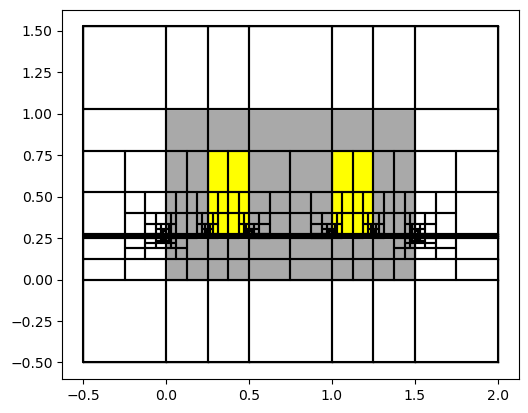

------------------------------------------------------
6
Number of DoFs: 8377
Energy: 0.0008807904496370311
Residual contributions took 3.4788522720336914 seconds.
Jump contributions took 9.070962190628052 seconds.
Refinement took 2.709939956665039 seconds for 64 patches.
Basis setup took 0.25830554962158203 seconds
Prolongation took 0.4696977138519287 seconds


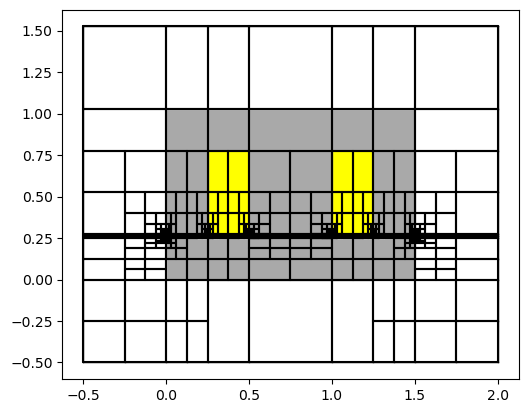

------------------------------------------------------
7
Number of DoFs: 11217
Energy: 0.0008818127041213609
Residual contributions took 4.675103664398193 seconds.
Jump contributions took 12.30972146987915 seconds.
Refinement took 4.785776853561401 seconds for 85 patches.
Basis setup took 0.36223506927490234 seconds
Prolongation took 0.633526086807251 seconds


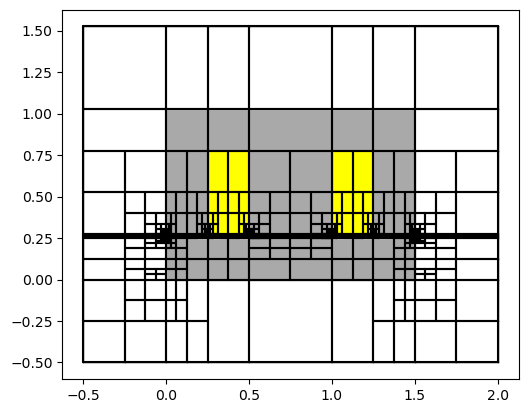

------------------------------------------------------
8
Number of DoFs: 15029
Energy: 0.0008824694503281166
Residual contributions took 6.266196966171265 seconds.
Jump contributions took 16.528103351593018 seconds.
Refinement took 7.750303268432617 seconds for 106 patches.
Basis setup took 0.4929220676422119 seconds
Prolongation took 0.8025248050689697 seconds


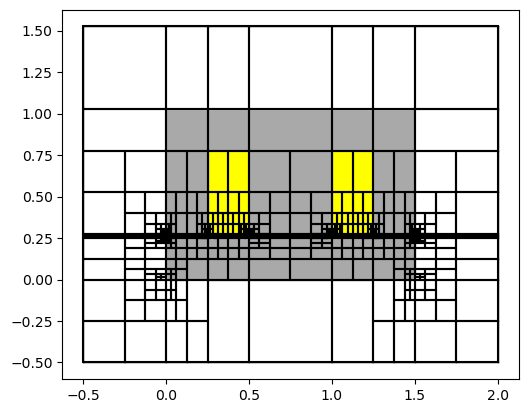

------------------------------------------------------
9
Number of DoFs: 19741
Energy: 0.0008830799289814081
Residual contributions took 8.207251071929932 seconds.
Jump contributions took 21.730515718460083 seconds.
Refinement took 10.514782905578613 seconds for 113 patches.
Basis setup took 0.6636185646057129 seconds
Prolongation took 0.8716821670532227 seconds


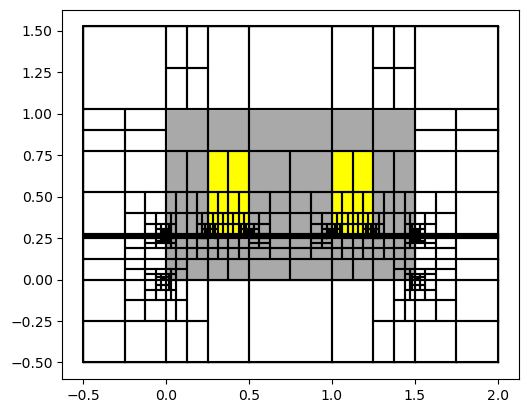

------------------------------------------------------
10
Number of DoFs: 24797
Energy: 0.0008832883591430715
Residual contributions took 10.437546968460083 seconds.
Jump contributions took 27.67790460586548 seconds.
Refinement took 18.14493751525879 seconds for 154 patches.
Basis setup took 1.0683314800262451 seconds
Prolongation took 1.23600172996521 seconds


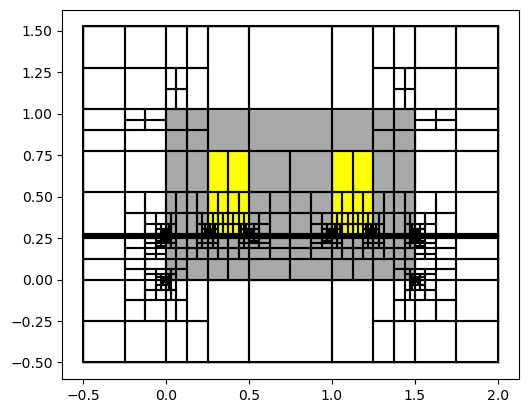

------------------------------------------------------
11
Number of DoFs: 31689
Energy: 0.000883547304194621
Residual contributions took 13.292446851730347 seconds.
Jump contributions took 35.58709001541138 seconds.
Refinement took 26.465750455856323 seconds for 177 patches.
Basis setup took 1.4950406551361084 seconds
Prolongation took 1.4970500469207764 seconds


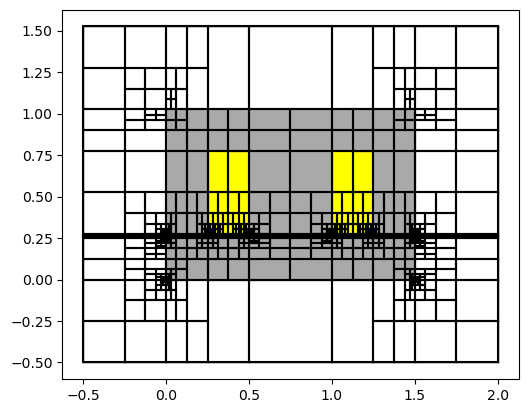

------------------------------------------------------
12
Number of DoFs: 39597
Energy: 0.0008838349599081773
Residual contributions took 16.69918656349182 seconds.
Jump contributions took 44.27176475524902 seconds.
Refinement took 45.317023515701294 seconds for 243 patches.
Basis setup took 2.0748627185821533 seconds
Prolongation took 2.0865907669067383 seconds


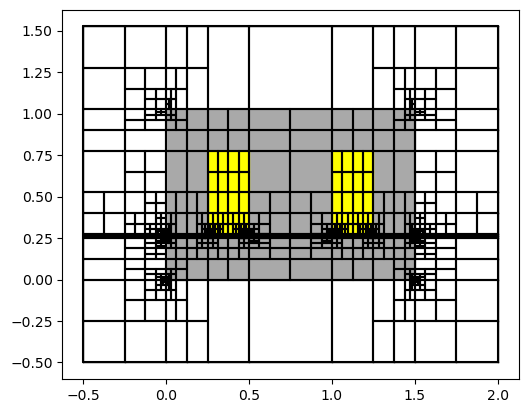

------------------------------------------------------
13
Number of DoFs: 50449
Energy: 0.0008841979656172935
Basis setup took 3.563960552215576 seconds
Prolongation took 6.976974010467529 seconds
------------------------------------------------------
14


KeyboardInterrupt: 

In [13]:
for deg, maxiter in zip((2,3,4),(18,20,25)):
    M_a=Inductor(deg,deg+1)
    MP_a = assemble.Multipatch(M_a, automatch=True)
    uh_a=[]
    P_a=[]
    err_ind=[]
    Eh_a=np.zeros(maxiter)

    numdofs_a =np.zeros(maxiter)
    err_est=np.zeros(maxiter)

    for i in range(maxiter):
        print('------------------------------------------------------')
        print(i)
        bcs = MP_a.compute_dirichlet_bcs({0:0.})
        Ah_a = sum([MP_a.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
        F = sum([MP_a.assemble_volume('j * v * dx', arity=1, domain_id=k, j=j[k], physical=True) for k in j],axis=0)
        Kh_a = MP_a.assemble_volume(vform.stiffness_vf(2))
        Mh_a = MP_a.assemble_volume(vform.mass_vf(2))

        LS = assemble.RestrictedLinearSystem(Ah_a, F, bcs)
        uh_a.append(LS.complete((cholesky(LS.A.tocsc()))(LS.b)))
        Eh_a[i]=MP_a.integrate('0.5 * nu * inner(grad(uh),grad(uh)) * v * dx', u_=uh_a[-1], nu=nu)*0.0254
        print('Number of DoFs: ' + str(MP_a.numdofs))
        print('Energy: ' + str(Eh_a[i]))
        numdofs_a[i]=MP_a.numdofs

        if i < maxiter-2 :
            err_ind.append(adap.PoissonEstimator(MP_a, uh_a[-1], f=j, a=nu, M=MaT))
            err_est[i] = norm(err_ind[-1])
            marked_patches = adap.doerfler_marking(err_ind[-1], 0.9)
            marked_patches = {p:None for p in marked_patches}
            P_a.append(MP_a.h_refine(h_ref=marked_patches, return_P=True))
            MP_a.mesh.draw(color={'C1':'yellow', 'C2':'yellow','Fe':'darkgrey','Air':'white'},knots=False)
            plt.show()
        elif i == maxiter-2:
            P_a.append(MP_a.p_refine(p_inc=1, return_P=True))
        else:
            pass

    for k in reversed(range(1,len(P_a))):
        P_a[k-1]=P_a[k]@P_a[k-1]

    L2err_a = np.zeros(maxiter)
    H1err_a = np.zeros(maxiter)
    Aherr_a = np.zeros(maxiter)
    Eherr_a = np.zeros(maxiter)
    for i in range(len(uh_a)-1):
        eh = P_a[i]@uh_a[i]-uh_a[-1]
        L2err_a[i] = eh @ Mh_a @ eh
        H1err_a[i] = eh @ Kh_a @ eh + L2err_a[-1]
        Aherr_a[i] = eh @ Ah_a @ eh
        Eherr_a[i]=abs(Eh_a[-1]-Eh_a[i])

    L2err_a = sqrt(L2err_a)
    H1err_a = sqrt(H1err_a)
    Aherr_a = sqrt(Aherr_a)

    np.savetxt('Ip'+str(deg)+'n'+str(deg+1)+'.txt', np.c_[[numdofs_a,H1err_a,L2err_a,Aherr_a]])

In [12]:
M = Inductor(2,3)
MP = assemble.Multipatch(M, automatch=True)
kvs, geos = MP.mesh.kvs, MP.mesh.geos

Basis setup took 0.013923168182373047 seconds


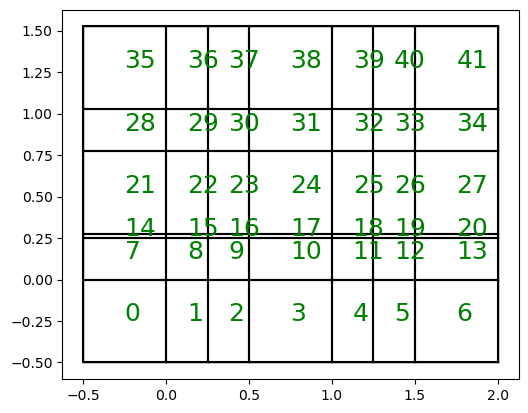

In [13]:
MP.mesh.draw(patch_idx=True)

In [48]:
nu['C1']/nu['Fe']

2500.0000000000005

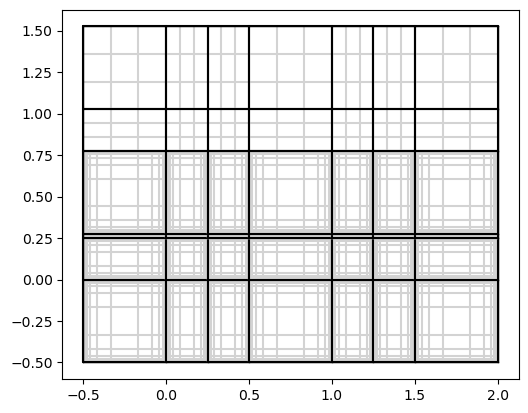

In [41]:
MP_geo.mesh.draw(knots=True)

In [8]:
for i in range(3):
    MP.h_refine();
    adap.PoissonEstimator(MP, uh = np.zeros(MP.numdofs))

Refinement took 0.3822510242462158 seconds for 42 patches.
Basis setup took 0.07076001167297363 seconds
Residual contributions took 1.3554270267486572 seconds.
Refinement took 4.167315483093262 seconds for 168 patches.
Basis setup took 0.2773246765136719 seconds
Residual contributions took 3.829657554626465 seconds.
Refinement took 60.90325403213501 seconds for 672 patches.
Basis setup took 1.7740912437438965 seconds
Residual contributions took 15.303276300430298 seconds.


In [36]:
adap.PoissonEstimator(MP, uh = np.zeros(MP.numdofs))

Residual contributions took 0.9817352294921875 seconds.


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [20]:
len(MP.N_ofs)

43

In [85]:
MP.N_ofs

array([   0,   25,   50,   75,  100,  125,  150,  175,  200,  225,  250,  275,  300,  325,  350,  375,  400,  425,  450,  475,  500,  525,  550,  575,  600,  625,  650,  675,  700,  725,  750,  775,  800,  825,  850,  875,  900,  925,  950,  975, 1000, 1025, 1050])

In [68]:
uh_loc = np.zeros(MP.numloc_dofs)

In [80]:
p=7
uh_loc[MP.N_ofs[p]:MP.N_ofs[p+1]]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [92]:
R = np.array([assemble.assemble('(f + div(grad(uh))) * v * dx', kvs=kv0 , geo=geo , f=lambda x,y: 1.,uh=geometry.BSplineFunc(kv, uh_loc[MP.N_ofs[p]:MP.N_ofs[p+1]])).ravel() for p, (kv0, kv, geo) in enumerate(zip(kvs0,kvs,geos))])

In [100]:
h**2 * R.sum(axis=1)

array([1.38889e-02, 4.34028e-03, 4.34028e-03, 1.38889e-02, 4.34028e-03, 4.34028e-03, 1.38889e-02, 4.34028e-03, 8.68056e-04, 8.68056e-04, 4.34028e-03, 8.68056e-04, 8.68056e-04, 4.34028e-03, 3.48090e-04, 4.38368e-05, 4.38368e-05, 3.48090e-04, 4.38368e-05, 4.38368e-05, 3.48090e-04, 1.38889e-02, 4.34028e-03, 4.34028e-03, 1.38889e-02, 4.34028e-03, 4.34028e-03, 1.38889e-02, 4.34028e-03, 8.68056e-04, 8.68056e-04, 4.34028e-03, 8.68056e-04, 8.68056e-04, 4.34028e-03, 1.38889e-02, 4.34028e-03, 4.34028e-03, 1.38889e-02, 4.34028e-03, 4.34028e-03, 1.38889e-02])

In [98]:
R.sum(axis=1)

array([0.25   , 0.125  , 0.125  , 0.25   , 0.125  , 0.125  , 0.25   , 0.125  , 0.0625 , 0.0625 , 0.125  , 0.0625 , 0.0625 , 0.125  , 0.0125 , 0.00625, 0.00625, 0.0125 , 0.00625, 0.00625, 0.0125 , 0.25   , 0.125  , 0.125  , 0.25   , 0.125  , 0.125  , 0.25   , 0.125  , 0.0625 , 0.0625 , 0.125  , 0.0625 , 0.0625 , 0.125  , 0.25   , 0.125  , 0.125  , 0.25   , 0.125  , 0.125  , 0.25   ])

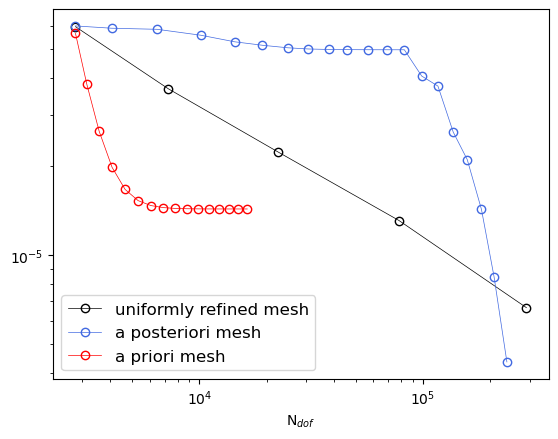

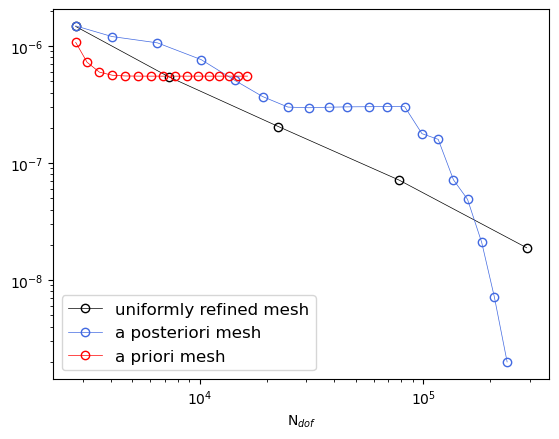

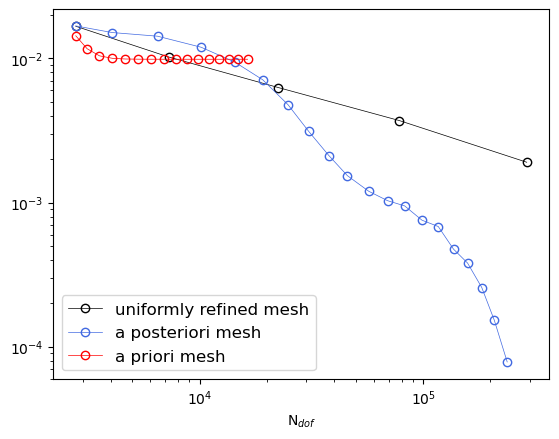

In [11]:
deg=4
[numdofs,H1err,L2err,Aherr]=np.loadtxt('Ip'+str(deg)+'n'+str(deg+1)+'uni.txt')
[numdofs_a,H1err_a,L2err_a,Aherr_a]=np.loadtxt('Ip'+str(deg)+'n'+str(deg+1)+'.txt')
[numdofs_geo,H1err_geo,L2err_geo,Aherr_geo]=np.loadtxt('Ip'+str(deg)+'n'+str(deg+1)+'geo.txt')

fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], H1err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], H1err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_geo[:-4], H1err_geo[:-4], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['uniformly refined mesh','a posteriori mesh','a priori mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

#draw_loglog_slope(fig,ax,(1e5,1.9*1e-2),1,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#draw_loglog_slope(fig,ax,(5*1e4,9*1e-3),1,int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

plt.savefig('/home/wolfman/Pictures/Motor/p'+str(deg)+'/Mp'+str(deg)+'n'+str(deg+1)+'H1.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], L2err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_geo[:-4], L2err_geo[:-4], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['uniformly refined mesh','a posteriori mesh','a priori mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

#draw_loglog_slope(fig,ax,(1e5,2.5*1e-5),1,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
#draw_loglog_slope(fig,ax,(5*1e4,2.5*1e-6),1,int((deg+1)/2) if (deg+1)%2==0 else (deg+1)/2,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

#fig, ax = plt.subplots()
# plt.loglog(numdofs[:-1], Aherr[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
# plt.loglog(numdofs_a[:-1], Aherr_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
# plt.loglog(numdofs_geo[:-1], Aherr_geo[:-1], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.savefig('/home/wolfman/Pictures/Motor/p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2.pdf', bbox_inches='tight')

fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], Aherr[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], Aherr_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_geo[:-4], Aherr_geo[:-4], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['uniformly refined mesh','a posteriori mesh','a priori mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

plt.show()



In [10]:
H1err_a

array([0.00014, 0.00013, 0.00011, 0.00011, 0.0001 , 0.0001 , 0.0001 , 0.0001 , 0.0001 , 0.     ])

In [11]:
L2err_a

array([8.16256e-06, 6.96800e-06, 3.68782e-06, 2.46796e-06, 1.95109e-06, 1.85318e-06, 1.85839e-06, 1.86715e-06, 1.87316e-06, 0.00000e+00])

In [20]:
Eerr

array([6.99408e-05, 3.97206e-05, 1.91405e-05, 7.74537e-06, 2.38368e-06, 1.22320e-07, 0.00000e+00])

In [16]:
Eerr

array([6.99408e-05, 3.97206e-05, 1.91405e-05, 7.74537e-06, 2.38368e-06, 1.22320e-07, 0.00000e+00])

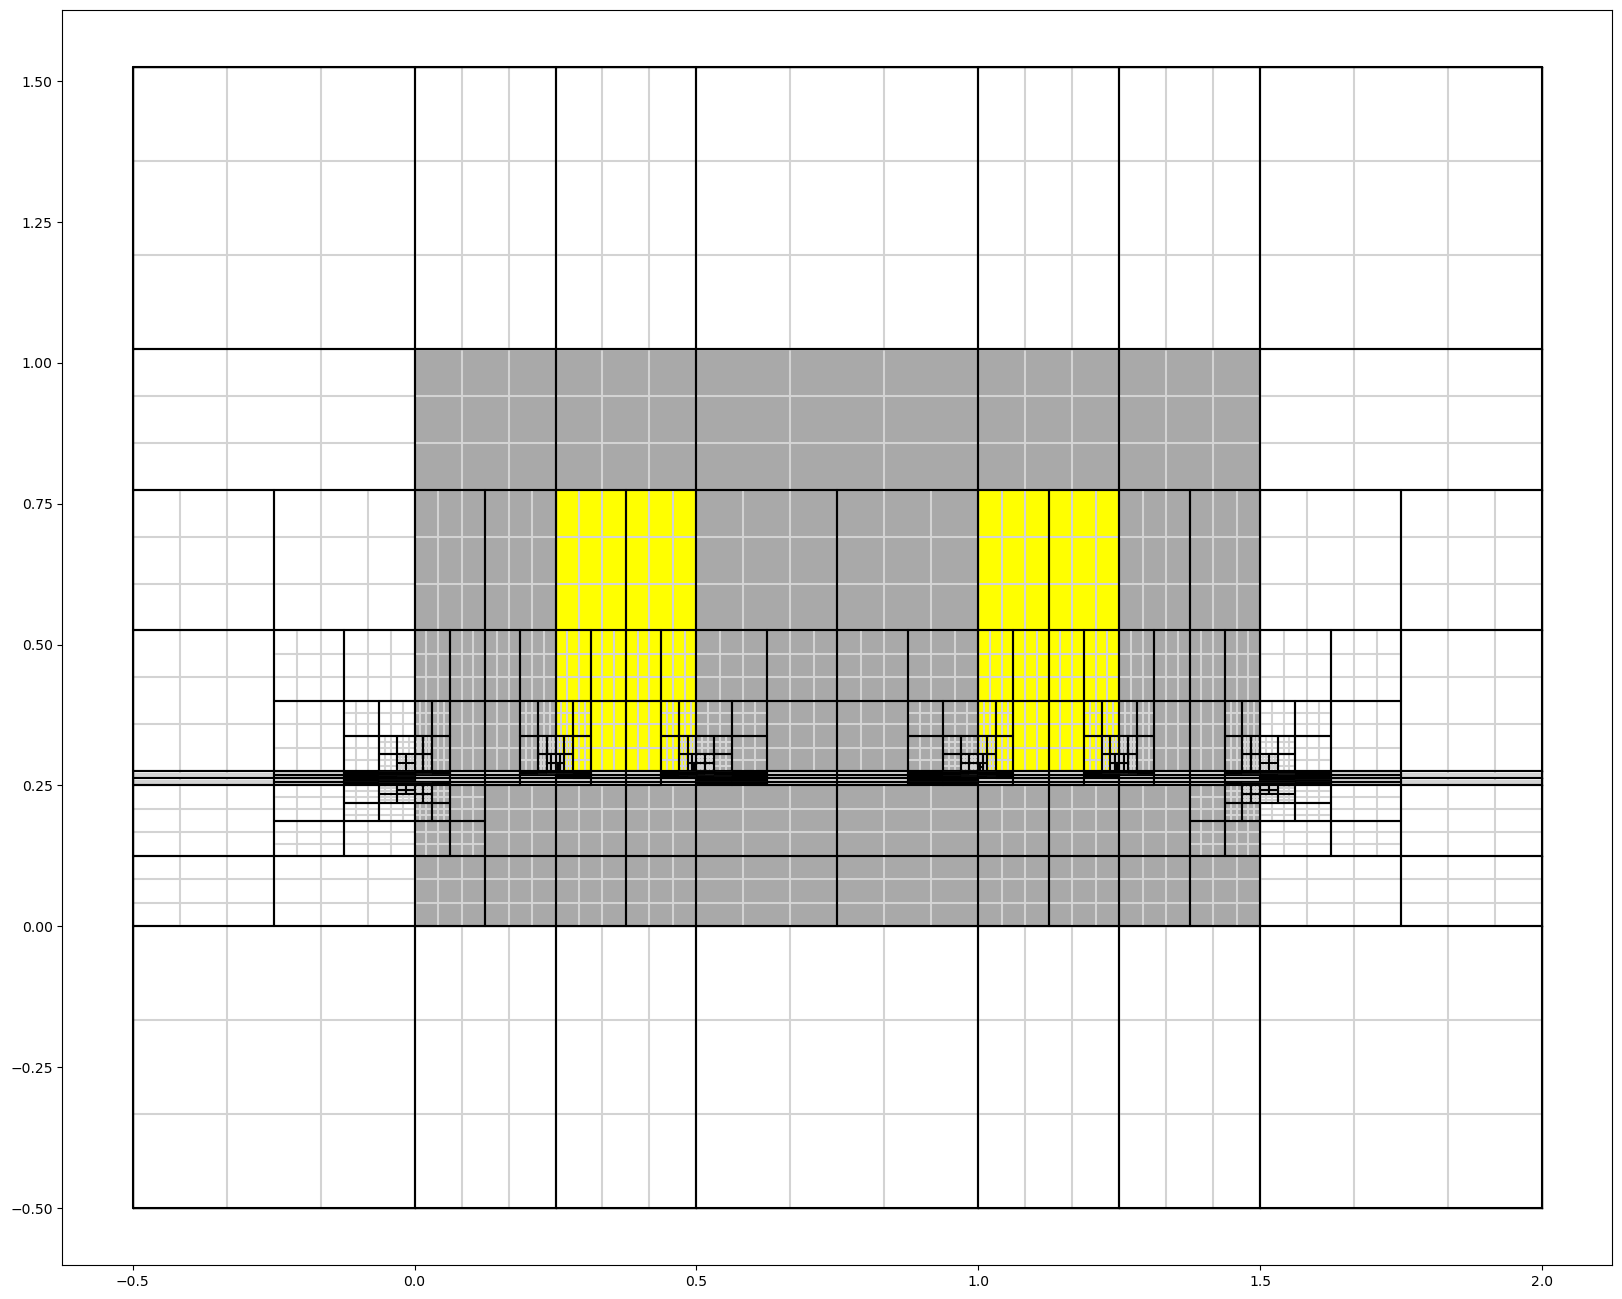

In [34]:
MP_a.mesh.draw(knots=True, color={'C1':'yellow', 'C2':'yellow','Fe':'darkgrey','Air':'white'}, figsize=(20,20))

In [ ]:
M.draw(knots=True, patch_idx=False, figsize=(10,10), color={'Air':'white', 'Fe':'darkgray', 'C1':'yellow', 'C2':'yellow'})

In [12]:
MP_a.integrate

{'Air': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}}

In [24]:
bd1=geometry.line_segment((1,0),(2,0))
bd3=geometry.line_segment((0,1),(0,2))
bd4=geometry.line_segment((0,1),(1,0))

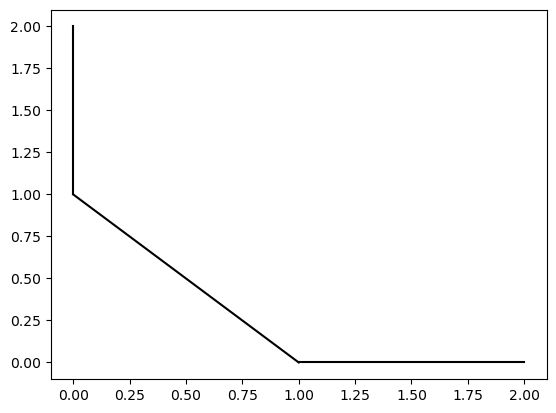

In [26]:
vis.plot_geo(bd3)
vis.plot_geo(bd3)
vis.plot_geo(bd4)

In [36]:
bd2=geometry.BSplineFunc(bspline.KnotVector(np.array([0,0,0,1,1,1]),2),coeffs=np.array([[2.,0.],
                                                                                        [2.,2.],
                                                                                        [0.,2.]]))

In [53]:
bd1.kvs

(KnotVector(array([0., 0., 1., 1.]), 1),)

In [59]:
geo=geometry.quarter_annulus()

In [61]:
geo.coeffs_weights()

(array([[[1., 0.],
         [2., 0.]],
 
        [[1., 1.],
         [2., 2.]],
 
        [[0., 1.],
         [0., 2.]]]),
 array([[1.     , 1.     ],
        [0.70711, 0.70711],
        [1.     , 1.     ]]))

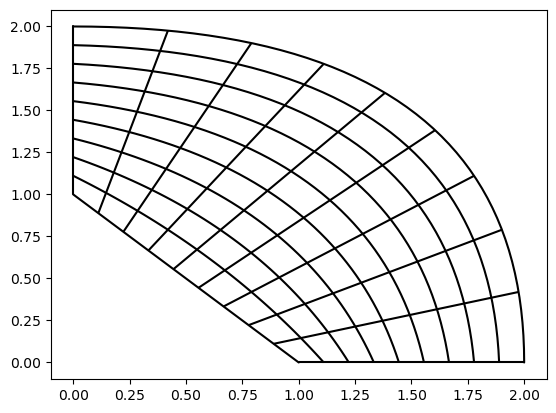

In [3]:
vis.plot_geo(geometry.bspline_annuseg())